### Figure insensitive hyper parameter


### Read data

In [ ]:
import os
# For Tuning Data
experiments_path = '../experiments/tuning_linear'
csv_save_path = '../test/all_result/tuning_linear_results.csv'

# function read_files: Read all name files in a directory and sub directories
def read_files(path, name):
    file_lists = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(name):
                file_lists.append(os.path.join(root, file))
    return file_lists

all_arg_file_list = read_files(experiments_path, 'args.yaml')
all_metrics_file_list = read_files(experiments_path, 'metrics.yaml')

assert len(all_arg_file_list) >= len(all_metrics_file_list)

# read data and create DataFrame
import pandas as pd
import yaml

args_columns = ['name', 'save_dir', 'dataset', 'homophily_with_train_idx', 
                'feature_norm_fn', 'node_selection_fn_name', 'ratio', 'bin_rank',
                'model', 'num_layers', 'num_layers_1', 'hidden_dim', 'hidden_dim_1',
                'hidden_dim_multiplier', 'num_heads', 'normalization', 'graph_self_loop', 'dropout',
                'weight_decay', 'lr', 'num_steps', 'num_warmup_steps', 'warmup_proportion',
                'use_sgc_features', 'use_identity_features', 'use_adjacency_features', 'do_not_use_original_features',
                'num_runs', 'device', 'amp', 'verbose']

result_columns = ['num runs', 'val accuracy mean', 'val accuracy std', 'test accuracy mean', 'test accuracy std',
                  'val ROC AUC mean', 'test ROC AUC mean', 'val ROC AUC std', 'test ROC AUC std',
                  'val accuracy values', 'test accuracy values', 'val ROC AUC values', 'test ROC AUC values', 'best steps']

items = []
for arg_file in all_arg_file_list:
    arg_file_name = os.path.basename(arg_file)
    metrics_file = os.path.join(os.path.dirname(arg_file), 'metrics.yaml')
    item = {}
    with open(arg_file, 'r') as f:
        args = yaml.load(f, Loader=yaml.FullLoader)
        for key in args_columns:
            if key in args:
                item[key] = args[key]
    if os.path.exists(metrics_file):
        with open(metrics_file, 'r') as f:
            metrics = yaml.load(f, Loader=yaml.FullLoader)
            for key in result_columns:
                if key in metrics:
                    item[key] = metrics[key]
    items.append(item)

all_df = pd.DataFrame(items)
# save to csv and can load back
if not os.path.exists(csv_save_path):
    all_df.to_csv(csv_save_path, index=False)

In [6]:
# For GNN GFS
import pandas as pd
import numpy as np

# data generate by get_tuning_paramater.ipynb
hp_df = pd.read_csv('../test/all_result/tuning_linear_results.csv')
tuning_df = pd.read_csv('../test/all_result/tuning_results.csv')
# tuning_df = pd.read_csv('../test/all_result/all_results.csv')
tuning_df = tuning_df[tuning_df['ratio'].astype(str).isin(['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9'])]

DATASETS = ["Children", "Computers", "Fitness", "History", "Photo", "amazon-ratings", "minesweeper", "questions", "roman-empire", "tolokers"]
DATASETS_SHOW_NAME = ["Children", "Comp.", "Fitness", "History", "Photo", "Amazon.", "Mines.", "Questions", "Roman.", "Tolokers"]

GNN_GFS_MODEL = ['GCN-MLP']
GNN_GFS_SHOW_NAME = ['GCN+GFS']

GNN_GFS_NAME = [f"{model}" for model in GNN_GFS_MODEL]

HYPERPARAMETERS = ['num_layers', 'hidden_dim', 'lr', 'weight_decay', 'dropout', 'ratio']
hp_default = [2, 512, 3e-5, 0, 0.2, 0.7]

latex_tuning_data = []

for idx, tuning_model in enumerate(GNN_GFS_MODEL):
    tuning_data = tuning_df[(tuning_df['model'] == GNN_GFS_MODEL[idx])
                            & (tuning_df['homophily_with_train_idx'].astype(str) == 'True')
                            & (tuning_df['dataset'].astype(str).isin(DATASETS))]
    tuning_data = tuning_data.filter(items=HYPERPARAMETERS + ['dataset', 'test accuracy mean', 'test accuracy std', 'test ROC AUC mean', 'test ROC AUC std'])
    for dataset in DATASETS:
        dataset_hp_acc = []
        if dataset not in tuning_data['dataset'].values:
            dataset_hp_acc = hp_default + ['-1, -1']
        elif tuning_data[tuning_data['dataset'] == dataset]['test accuracy mean'].values.tolist() == []:
            hp_acc = tuning_data[tuning_data['dataset'] == dataset]
            dataset_hp_acc = [hp_acc[pn].values[0] for pn in HYPERPARAMETERS] + ['-1, -1']
        elif not pd.Series(tuning_data[tuning_data['dataset'] == dataset]['test accuracy mean'].values).isna()[0]:
            tuning_means = np.array(tuning_data[tuning_data['dataset'] == dataset]['test accuracy mean'].values)
            tuning_stds = np.array(tuning_data[tuning_data['dataset'] == dataset]['test accuracy std'].values)
            tuning_hp = np.array(tuning_data[tuning_data['dataset'] == dataset][HYPERPARAMETERS].values)
            for item in tuning_hp[tuning_means.argmax()]:
                dataset_hp_acc.append(item) 
            dataset_hp_acc.append(f"{tuning_means.max() * 100:.2f}±{tuning_stds[tuning_means.argmax()] * 100:.2f}")         
        else:
            tuning_means = np.array(tuning_data[tuning_data['dataset'] == dataset]['test ROC AUC mean'].values)
            tuning_stds = np.array(tuning_data[tuning_data['dataset'] == dataset]['test ROC AUC std'].values)
            tuning_means = np.nan_to_num(tuning_means, nan=0.0)
            for item in tuning_hp[tuning_means.argmax()]:
                dataset_hp_acc.append(item) 
            dataset_hp_acc.append(f"{tuning_means.max() * 100:.2f}±{tuning_stds[tuning_means.argmax()] * 100:.2f}")
        latex_tuning_data.append([dataset] + dataset_hp_acc)
hp_base_df = pd.DataFrame(latex_tuning_data, columns=(['DATASET'] + HYPERPARAMETERS + ['Mean+Std']))
hp_base_df

,DATASET,num_layers,hidden_dim,lr,weight_decay,dropout,ratio,Mean+Std
0,Children,2.0,256.0,0.00100,0.00010,0.2,0.5,59.14±0.30
1,Computers,3.0,512.0,0.00010,0.00003,0.3,0.8,90.07±0.19
2,Fitness,2.0,512.0,0.00003,0.00000,0.2,0.7,"-1, -1"
3,History,2.0,128.0,0.00100,0.00030,0.4,0.5,84.83±0.28
4,Photo,3.0,256.0,0.00100,0.00030,0.5,0.6,86.74±0.32
5,amazon-ratings,2.0,512.0,0.00100,0.00100,0.4,0.6,53.32±0.81
6,minesweeper,2.0,512.0,0.00001,0.00100,0.4,0.6,89.99±0.60
7,questions,3.0,128.0,0.00100,0.00030,0.2,0.6,76.50±1.38
8,roman-empire,3.0,128.0,0.00100,0.00010,0.3,0.6,82.34±0.56
9,tolokers,2.0,512.0,0.00010,0.00001,0.2,0.6,85.01±0.91


### Select Data

In [7]:
# DRAW_HP = ['num_layers', 'hidden_dim'] # ['num_layers', 'hidden_dim', 'lr', 'weight_decay', 'dropout']
DRAW_HP = ['num_layers', 'hidden_dim', 'lr', 'weight_decay', 'dropout']

DATASETS_SHOW = ["Children", "Computers", "Fitness", "History", "Photo", "amazon-ratings", "minesweeper", "questions", "roman-empire", "tolokers"]
DATASETS_SHOW_NAME = {
    "Children": "Children",
    "Computers": "Comp.",
    "Fitness": "Fitness",
    "History": "History",
    "Photo": "Photo",
    "amazon-ratings": "Amazon.",
    "minesweeper": "Mines.",
    "questions": "Questions",
    "roman-empire": "Roman.",
    "tolokers": "Tolokers"
}
# DATASETS_SHOW = ["Computers", "amazon-ratings"]
# DATASETS_SHOW_NAME = {
#     "Computers": "Comp.",
#     "amazon-ratings": "Amazon."
# }

hp_df = hp_df.filter(items=HYPERPARAMETERS + ['dataset', 'test accuracy mean', 'test accuracy std', 'test ROC AUC mean', 'test ROC AUC std'])

num_layers = [i for i in range(1, 11)]
hidden_dim = [16, 32, 64, 128, 256, 512, 1024]
lr = [3e-5, 1e-5, 3e-4, 1e-4, 3e-3, 1e-3, 3e-2, 1e-2]
weight_decay = [0, 1e-3, 3e-4, 1e-4, 3e-5, 1e-5]
dropout = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

means_groups_test_gcn = []
stds_groups_test_gcn = []
means_groups_test_mlp = []
stds_groups_test_mlp = []
means_groups_test_tfs = []
stds_groups_test_tfs = []
figure_names = []


for dataset in DATASETS_SHOW:
    for hp in DRAW_HP:
        default_hp = hp_base_df[hp_base_df['DATASET'] == dataset]
        # break
        means_gruop_test_gcn = []
        stds_group_test_gcn = []
        means_group_test_mlp = []
        stds_group_test_mlp = []
        means_group_test_tfs = []
        stds_group_test_tfs = []
        hp_data = hp_df[(hp_df['dataset'] == dataset)]
        for param in HYPERPARAMETERS:
            if param != hp and param != 'ratio':
                hp_data = hp_data[hp_data[param].astype(type(default_hp[param].values[0])) == default_hp[param].values[0]]
        hp_gcn_data = hp_data[hp_data['ratio'].astype(float) == 1.0]
        hp_mlp_data = hp_data[hp_data['ratio'].astype(float) == 0]
        hp_tfs_data = hp_data[(hp_data['ratio'].astype(float) != 0) & (hp_data['ratio'].astype(float) != 1.0)]
        for hp_value in eval(f"{hp}"):
            hp_gcn_data_value = hp_gcn_data[hp_gcn_data[hp] == hp_value]
            hp_mlp_data_value = hp_mlp_data[hp_mlp_data[hp] == hp_value]
            hp_tfs_data_value = hp_tfs_data[hp_tfs_data[hp] == hp_value]
            if hp_gcn_data_value.empty:
                means_gruop_test_gcn.append(-1)
                stds_group_test_gcn.append(-1)
            elif not pd.Series(hp_gcn_data_value[hp_gcn_data_value['dataset'] == dataset]['test accuracy mean'].values).isna()[0]:
                means_gruop_test_gcn.append(hp_gcn_data_value['test accuracy mean'].values[0])
                stds_group_test_gcn.append(hp_gcn_data_value['test accuracy std'].values[0])
            else:
                means_gruop_test_gcn.append(hp_gcn_data_value['test ROC AUC mean'].values[0])
                stds_group_test_gcn.append(hp_gcn_data_value['test ROC AUC std'].values[0])
            if hp_mlp_data_value.empty:
                means_group_test_mlp.append(-1)
                stds_group_test_mlp.append(-1)
            elif not pd.Series(hp_mlp_data_value[hp_mlp_data_value['dataset'] == dataset]['test accuracy mean'].values).isna()[0]:
                means_group_test_mlp.append(hp_mlp_data_value['test accuracy mean'].values[0])
                stds_group_test_mlp.append(hp_mlp_data_value['test accuracy std'].values[0])
            else:
                means_group_test_mlp.append(hp_mlp_data_value['test ROC AUC mean'].values[0])
                stds_group_test_mlp.append(hp_mlp_data_value['test ROC AUC std'].values[0])
            if hp_tfs_data_value.empty:
                means_group_test_tfs.append(-1)
                stds_group_test_tfs.append(-1)
            elif not pd.Series(hp_tfs_data_value[hp_tfs_data_value['dataset'] == dataset]['test accuracy mean'].values).isna()[0]:
                means_group_test_tfs.append(hp_tfs_data_value['test accuracy mean'].values[0])
                stds_group_test_tfs.append(hp_tfs_data_value['test accuracy std'].values[0])
            else:
                means_group_test_tfs.append(hp_tfs_data_value['test ROC AUC mean'].values[0])
                stds_group_test_tfs.append(hp_tfs_data_value['test ROC AUC std'].values[0])
        means_groups_test_gcn.append(means_gruop_test_gcn)
        stds_groups_test_gcn.append(stds_group_test_gcn)
        means_groups_test_mlp.append(means_group_test_mlp)
        stds_groups_test_mlp.append(stds_group_test_mlp)
        means_groups_test_tfs.append(means_group_test_tfs)
        stds_groups_test_tfs.append(stds_group_test_tfs)
        figure_names.append(f"{dataset}__{hp}")
len(means_groups_test_gcn), len(means_groups_test_gcn[0])

(50, 10)

### Draw Figure

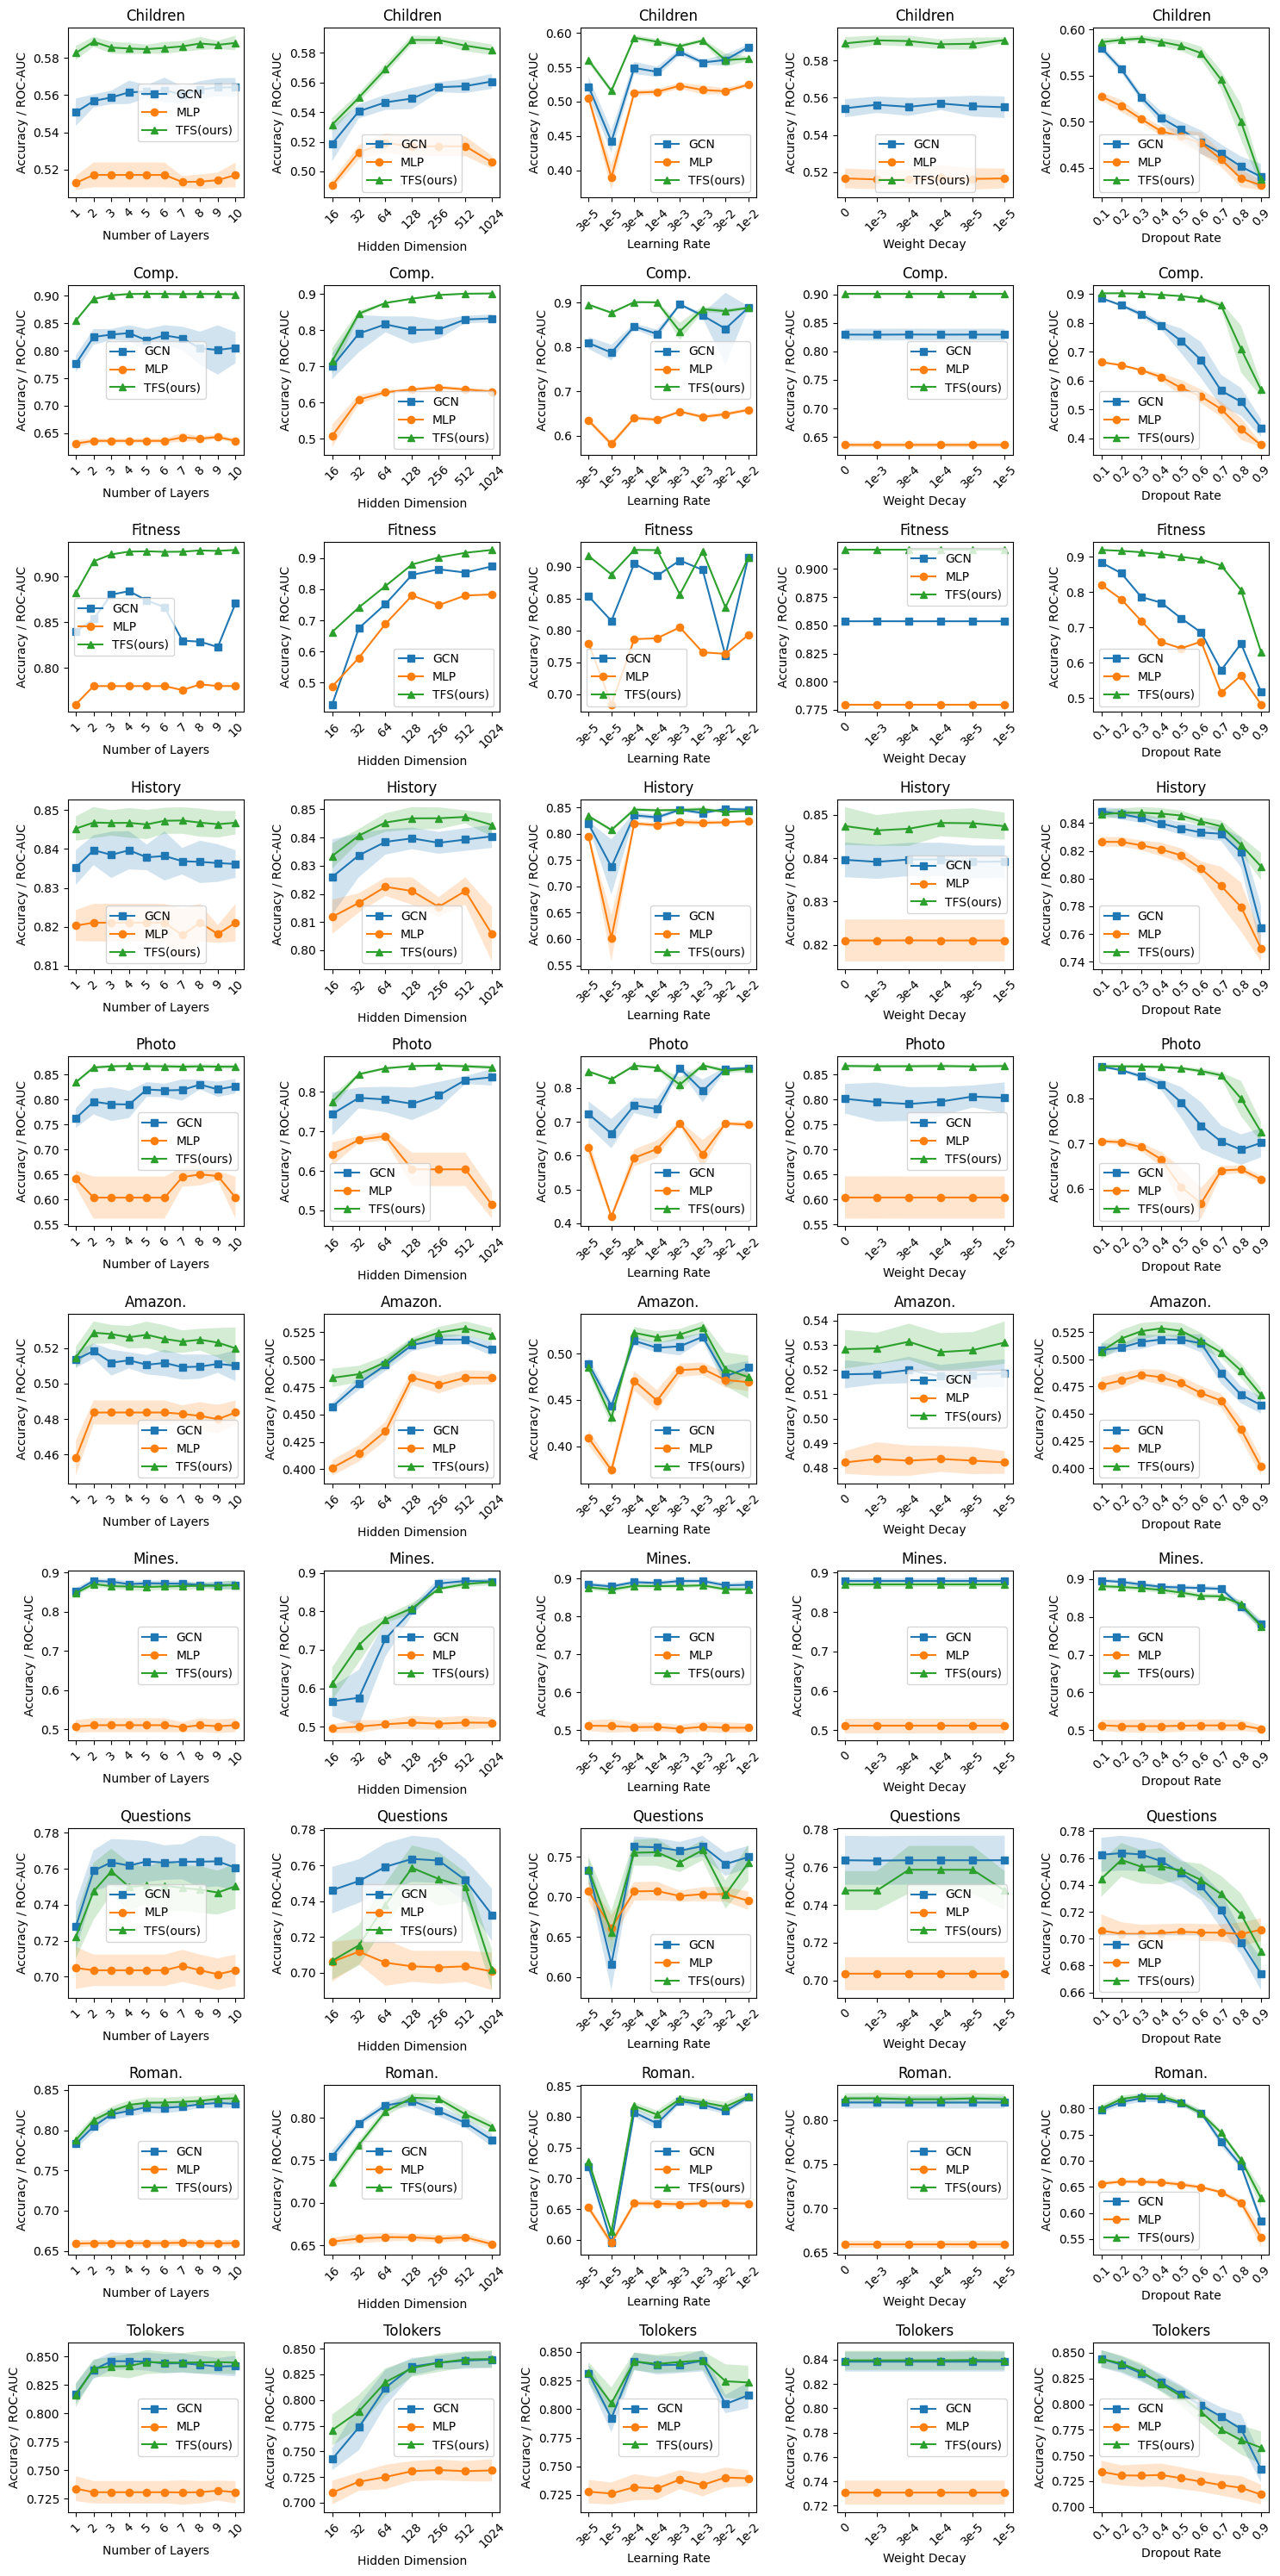

In [8]:
import matplotlib.pyplot as plt
import numpy as np

HP_NAME_SHOE = {
    'num_layers': 'Number of Layers',
    'hidden_dim': 'Hidden Dimension',
    'lr': 'Learning Rate',
    'weight_decay': 'Weight Decay',
    'dropout': 'Dropout Rate'
}

figure_total_number = len(figure_names)
figure_per_row = len(DRAW_HP)
fig, axs = plt.subplots(figure_total_number // figure_per_row, figure_per_row, figsize=(15, 3 * figure_total_number // figure_per_row)) # for fn3_nsf5

for idx, figure_name in enumerate(figure_names):
    row = idx // figure_per_row
    col = idx % figure_per_row
    ax = axs[row, col]
    dataset_name, hp_name = figure_name.split('__')
    if -1 in means_groups_test_gcn[idx]:
        continue
    # ax.errorbar(eval(f"{hp_name}"), means_groups_test_gcn[idx], yerr=stds_groups_test_gcn[idx], fmt='-o', label='GCN', color='b')
    # ax.errorbar(eval(f"{hp_name}"), means_groups_test_mlp[idx], yerr=stds_groups_test_mlp[idx], fmt='-o', label='MLP', color='r')
    # ax.errorbar(eval(f"{hp_name}"), means_groups_test_tfs[idx], yerr=stds_groups_test_tfs[idx], fmt='-o', label='TFS', color='g')
    x = [i for i in range(len(eval(f"{hp_name}")))]
    if float(eval(f"{hp_name}")[0]) < 0.05:
        x_show = [f"{i:.0e}" for i in eval(f"{hp_name}")]
        x_show = [item.replace('e-0', 'e-') for item in x_show]
        x_show = [item.replace('0e+00', '0') for item in x_show]
    else:
        x_show = [f"{str(i)}" for i in eval(f"{hp_name}")]
    ax.errorbar(x, means_groups_test_gcn[idx], fmt='-s', capsize=5, capthick=2, label='GCN')
    ax.fill_between(x, 
                    np.array(means_groups_test_gcn[idx]) - np.array(stds_groups_test_gcn[idx]), 
                    np.array(means_groups_test_gcn[idx]) + np.array(stds_groups_test_gcn[idx]), alpha=0.2)
    ax.errorbar(x, means_groups_test_mlp[idx], fmt='-o', label='MLP')
    ax.fill_between(x, 
                    np.array(means_groups_test_mlp[idx]) - np.array(stds_groups_test_mlp[idx]), 
                    np.array(means_groups_test_mlp[idx]) + np.array(stds_groups_test_mlp[idx]), alpha=0.2)
    ax.errorbar(x, means_groups_test_tfs[idx], fmt='-^', label='TFS(ours)')
    ax.fill_between(x, 
                    np.array(means_groups_test_tfs[idx]) - np.array(stds_groups_test_tfs[idx]), 
                    np.array(means_groups_test_tfs[idx]) + np.array(stds_groups_test_tfs[idx]), alpha=0.2)
    
    ax.set_xticks(x)
    ax.set_xticklabels(x_show, rotation=45)
    ax.set_title(f"{DATASETS_SHOW_NAME[dataset_name]}")
    ax.set_xlabel(f"{HP_NAME_SHOE[hp_name]}")
    ax.set_ylabel('Accuracy / ROC-AUC')
    ax.legend()

plt.subplots_adjust(hspace=1., wspace=1.0) 
plt.tight_layout()
plt.savefig('../figure/insensitive_hyper_param.pdf', bbox_inches='tight')
plt.show()